## Suggested workflow

    [] Get the data for materials with both elastic properties and ones without
    [] Train a model using materials data with elastic props
    [] Test my model with materials having calculated elastic properties
    [] Plot the results for a perspective on the accuracies
    [] Then use the model to predict the elastic props of materials without
    [] Plot the results to get a feel of the magnitude of the predicted elastic props
    [] Get a select few of the materials with predicted high props and study more


### Step 1: Get the data for materials with both elastic properties and ones without

In [18]:
import os, sys, random
from numpy import mat
import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sb

%matplotlib inline


In [3]:
API_TOKEN = os.environ.get("MPTOKEN")
DATA_PATH = ""
SCRIPT_PATH = ""
ROOT_DIR = "/".join(os.getcwd().split(os.sep)[:-1])
EPOCHS = 20

ROOT_DIR
API_TOKEN


'8HAUQF5KZainZ0p6b5kM'

In [4]:
## Contact the materials database API and get all Tarnery materials in the database
## - Will filter for the Metals and Nitrates later

try:
    
    with open(os.path.join(ROOT_DIR, "candidates.json"), 'r') as fo:
        print(f"Found candidates json file, using data from it...")
        materials = json.load(fo)

except Exception as e:
    print(f"Could not get candidates json file, getting data and creating cson file")
    
    mpr = MPRester(API_TOKEN)
    # mpr.materials.available_fields

    crt = {
        # 'elements': {'$all': ['N']},
        'nelements': 3,
        # 'band_gap': {'$lt': 1},
    }
    prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
            'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

    materials = mpr.query(criteria=crt, properties=prt)

    with open(os.path.join(ROOT_DIR, "candidates.json"), 'w') as fo:
        json.dump(materials, fo, indent=2)

Found candidates json file, using data from it...


In [5]:

print("Example material data:\n", json.dumps(materials[0], indent=2))
print("\n\n List of some of the materials:\n", [x['pretty_formula'] for x in materials[:20]])

Example material data:
 {
  "material_id": "mp-1004524",
  "pretty_formula": "HPbI3",
  "full_formula": "H1Pb1I3",
  "band_gap": 0.0,
  "unit_cell_formula": {
    "H": 1.0,
    "Pb": 1.0,
    "I": 3.0
  },
  "elements": [
    "H",
    "I",
    "Pb"
  ],
  "elasticity": null,
  "cif": "# generated using pymatgen\ndata_HPbI3\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   6.24421300\n_cell_length_b   6.24421300\n_cell_length_c   6.24421300\n_cell_angle_alpha   90.00000000\n_cell_angle_beta   90.00000000\n_cell_angle_gamma   90.00000000\n_symmetry_Int_Tables_number   1\n_chemical_formula_structural   HPbI3\n_chemical_formula_sum   'H1 Pb1 I3'\n_cell_volume   243.46308867\n_cell_formula_units_Z   1\nloop_\n _symmetry_equiv_pos_site_id\n _symmetry_equiv_pos_as_xyz\n  1  'x, y, z'\nloop_\n _atom_site_type_symbol\n _atom_site_label\n _atom_site_symmetry_multiplicity\n _atom_site_fract_x\n _atom_site_fract_y\n _atom_site_fract_z\n _atom_site_occupancy\n  H  H0  1  0.50000000  0.50000

In [6]:
CANDIDATES_WITH = []  # A list of candidate materials with elastic props
CANDIDATES_WITHOUT = [] # A list of candidate materials without elastic props
TMN_MATERIALS = []

for mat in materials:
    
    if mat['elasticity'] is None:
        CANDIDATES_WITHOUT.append(mat)
    else:
        CANDIDATES_WITH.append(mat)

with open(os.path.join(ROOT_DIR, "TMR_Data.json"), 'r') as fo:
    tmn_materials = json.load(fo)
    TMN_MATERIALS = tmn_materials.get('candidates')
    

print(f"Total Candidates: {len(materials)}")
print(f"Candidated found with elastic props: {len(CANDIDATES_WITH)}")
print(f"Candidated found without elastic props: {len(CANDIDATES_WITHOUT)}")
print(f"Total TMN materials: {len(TMN_MATERIALS)}")

Total Candidates: 59023
Candidated found with elastic props: 7372
Candidated found without elastic props: 51651
Total TMN materials: 2236


### Step 2: Train a model using materials data with elastic props
##### Step 2.1 Create The Training data

In [ ]:
ID_PROPS_DATA = []

## Create CIF files
print(f"Creating CIF files...")
for i in CANDIDATES_WITH:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = i['elasticity']['K_VRH']

    with open(os.path.join(ROOT_DIR, f"src/data/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating training data.")




Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating training data.


##### Step 2.2 Train the model

In [ ]:
main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/data")

run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
# cmd = "python -c print('Hello-world')"
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERROR >> {err.decode('utf-8')}")
# print(result.decode("utf-8"))


python "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 20 "c:\Users\PC\Documents\tony\Ternary-Metal-Nitrides-Research\src/data"
OUTPUT >> Epoch: [0][0/18]	Time 6.750 (6.750)	Data 5.749 (5.749)	Loss 3.3729 (3.3729)	MAE 117.867 (117.867)
Epoch: [0][10/18]	Time 4.590 (5.257)	Data 3.603 (4.058)	Loss 0.8073 (3.0405)	MAE 48.669 (94.539)
Test: [0/6]	Time 4.679 (4.679)	Loss 0.8847 (0.8847)	MAE 57.510 (57.510)
 * MAE 56.231
Epoch: [1][0/18]	Time 0.972 (0.972)	Data 0.028 (0.028)	Loss 0.8769 (0.8769)	MAE 56.798 (56.798)
Epoch: [1][10/18]	Time 1.508 (1.101)	Data 0.021 (0.015)	Loss 0.5600 (0.7736)	MAE 44.885 (51.831)
Test: [0/6]	Time 0.250 (0.250)	Loss 0.6272 (0.6272)	MAE 37.322 (37.322)
 * MAE 32.684
Epoch: [2][0/18]	Time 1.069 (1.069)	Data 0.021 (0.021)	Loss 0.5012 (0.5012)	MAE 30.793 (30.793)
Epoch: [2][10/18]	Time 1.023 (1.170)	Data 0.014 (0.015)	Loss 0.2106 (0.2784)	MAE 23.562 (26.393)
T

             material  test      result        error  square_error
0  Nd(PdO2)2_mp-15051   147  146.981110  0.000128506      2.356570
1    VZnO3_mp-1016931   178  178.040085  0.000225196      3.777803
2   SmHoZn2_mp-978537    58   57.981445  0.000319908      1.466970
3      PrAlO3_mp-8218   194  194.068146  0.000351267      5.142491
4   Ho2IrRh_mp-864625   125  125.060242  0.000481934      3.881244
Working on the scatter plot...
Done creating plots


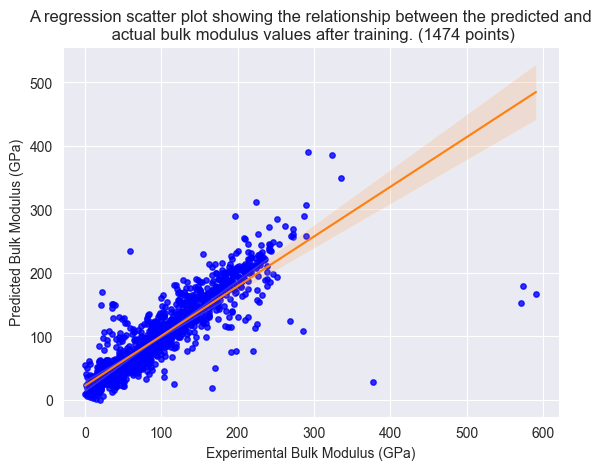

In [7]:
# result_file = os.path.join(ROOT_DIR, "src/test_results.csv")
result_file = os.path.join(ROOT_DIR, "src/test_results_publish.csv")

df = pd.read_csv(result_file)

df.dropna(subset=['material'], inplace=True)

print(df.head())

## Plot the scatter plot
print(f"Working on the scatter plot...")
color_dict = dict({'test':'brown',
                  'result':'green'})

sb.set_style("darkgrid")
ax = sb.regplot(x='test', y='result', data=df, line_kws={"color": "C1", 'linewidth': 1.5}, scatter_kws={'color': 'blue', 's': 15})
# ax = sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')
ax.set_title(f"A regression scatter plot showing the relationship between the predicted and\n actual bulk modulus values after training. ({len(df)} points)")
ax.set_xlabel("Experimental Bulk Modulus (GPa)")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")


print("Done creating plots")

#### 2.2.1 Create a similar scatter plot without the outliers

                material  test      result        error  square_error
1344     NbCrW_mp-631452   591  167.007233   0.71741585    566.912325
1350  Ti2InFe_mp-1018070   571  151.853928  0.734056169    550.437448
1337    VCdO3_mp-1016904   574  179.618027  0.687076608    545.172784
1376    PbBrCl_mp-995147   378   28.185379  0.925435505    376.947721
1323      UCuGe_mp-11833   286  108.925026  0.619143266    264.445342
1171     B2CN_mp-1008526   292  390.931152  0.338805316    259.929155
1293    NaReO3_mp-976923   269  124.400047  0.537546293    238.507082
1449     UCo3B2_mp-10056    59  234.774567  2.979229943    227.240175
1213      FeWN2_mp-29076   224  311.768250  0.391822542    216.848891
1268   Fe(BMo)2_mp-20278   197  289.385193   0.46896037    211.978277
963      B2CN_mp-1008527   324  385.523651  0.189887812    208.931772
1330    CsSnO3_mp-984745   220   77.486794  0.647787302    205.902396
1280    LiTcO3_mp-862870   223  113.427727  0.491355485    191.997789
1265    SnPbO3_mp-97

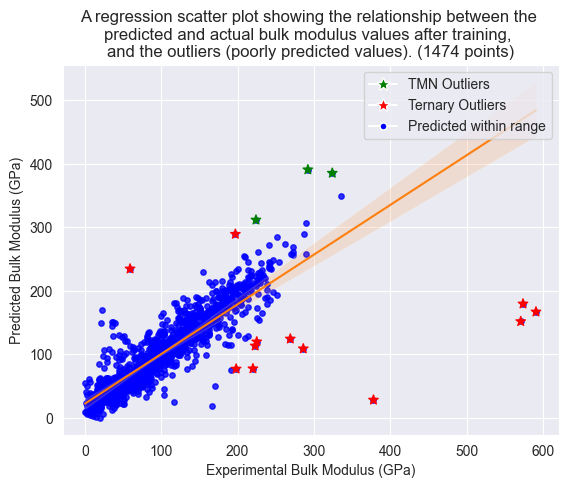

In [33]:
# Load the data from the CSV file
result_file = os.path.join(ROOT_DIR, "src/test_results_publish.csv")
df = pd.read_csv(result_file)
df.dropna(subset=['material'], inplace=True)
df.head()

# Convert the 'error' column to numeric data type
df['square_error'] = pd.to_numeric(df['square_error'], errors='coerce')

# Get the top 5 materials based on the highest values in 'error' column
outlier_materials = df.nlargest(15, 'square_error')
print(outlier_materials)

# Create a list of colors based on the presence of the 'N' element in material elements
colors = []
for mat in outlier_materials['material']:
    mat_id = mat.split('_')[-1]
    mat_obj = [m for m in materials if str(m.get('material_id')) == str(mat_id)][0]
    mat_elements = mat_obj.get('elements')

    colors.append('green' if 'N' in mat_elements else 'red')

    print(mat_obj.get('elements'))


# Create custom legend patches for colors
color_legend_patches = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='green', markersize=10, label='TMN Outliers'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=10, label='Ternary Outliers'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Predicted within range')
]

sb.set_style("darkgrid")
ax = sb.regplot(x='test', y='result', data=df, line_kws={"color": "C1", 'linewidth': 1.5}, scatter_kws={'color': 'blue', 's': 15})
ax.scatter(x=outlier_materials['test'], y=outlier_materials['result'], c=colors, s=50, marker='*', alpha=1.0)
# ax = sb.scatterplot(x="test", y="result", data=df, palette=color_dict, legend='full')
ax.set_title(f"A regression scatter plot showing the relationship between the \npredicted and actual bulk modulus values after training, \nand the outliers (poorly predicted values). ({len(df)} points)")
ax.set_xlabel("Experimental Bulk Modulus (GPa)")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")

# Create a legend with custom handles for colors and markers
ax.legend(handles=color_legend_patches, loc='upper right')

# ax.legend(handles=legend_patches, loc='lower right')


#### 2.2.2 Show the outliers onto a bar plot

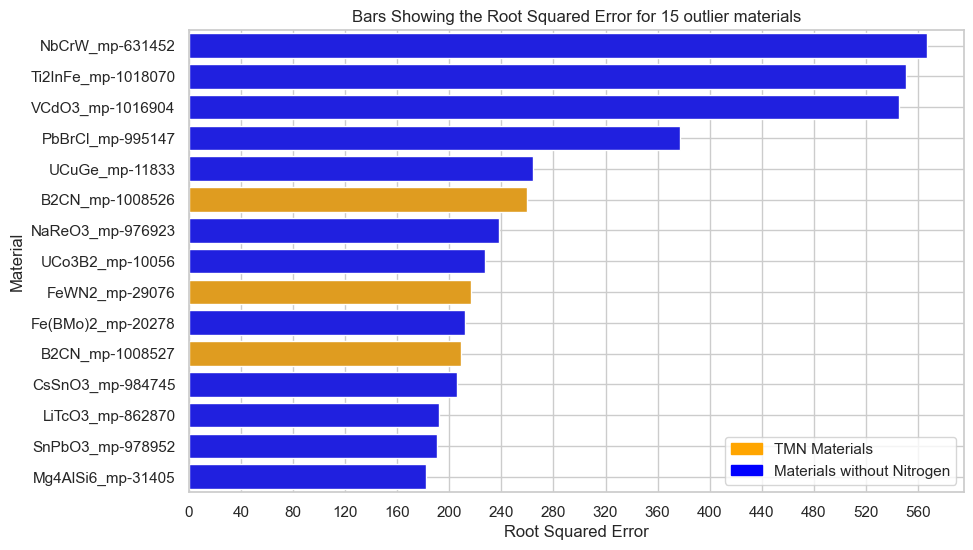

In [62]:
## Get the data
mats = outlier_materials['material']
square_errors = outlier_materials['square_error']

# Create a list of colors based on the presence of the 'N' element in material elements
colors = []
for mat in mats:
    mat_id = mat.split('_')[-1]
    mat_obj = [m for m in materials if str(m.get('material_id')) == str(mat_id)][0]
    mat_elements = mat_obj.get('elements')

    colors.append('orange' if 'N' in mat_elements else 'blue')
    
    # print(mat_obj.get('elements'))
    
# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='orange', label='TMN Materials'),
    mpatches.Patch(color='blue', label='Materials without Nitrogen')
]

# Set up Seaborn and Matplotlib for Jupyter Notebook
sb.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a horizontal bar plot using Seaborn
ax = sb.barplot(x=square_errors, y=mats, palette=colors)

# Create a legend using custom patches
ax.legend(handles=legend_patches, loc='lower right')

ax.set_xlabel('Root Squared Error')
ax.set_ylabel('Material')
ax.set_title(f'Bars Showing the Root Squared Error for {len(outlier_materials)} outlier materials')

# Show grid and increase y-axis ticks
ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=15))


### Step 3: Test my model with materials having calculated elastic properties

##### 3.1 Create data folder for prediction

In [ ]:
## Get the number of Ternary metal nitride materials in the dataset that dont have elastic properties
count = 0
for material in CANDIDATES_WITHOUT:

    ## Filter through only metal nitrides
    if material['band_gap'] < 1:
        continue
    
    if 'N' not in material['elements']:
        continue

    count += 1

print(f"Number of T.M.N materials without elastic properties {count} out of {len(CANDIDATES_WITHOUT)}")

Number of T.M.N materials without elastic properties 1176 out of 51651


In [ ]:
ID_PROPS_DATA = []



## Create CIF files for materials without elastic props
print(f"Creating CIF files...")
_CANDIDATES_WITHOUT = random.choices(CANDIDATES_WITHOUT, k=20)
for i in CANDIDATES_WITHOUT:

    ## Filter through only metal nitrides
    if i['band_gap'] < 1:
        continue
    
    if 'N' not in i['elements']:
        continue
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}" # String Formatting
    bulk_modulus = random.randint(1, 999)

    with open(os.path.join(ROOT_DIR, f"src/data_predict/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data_predict/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data_predict/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating predicting data.")

Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating predicting data.


In [ ]:

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/data_predict")
bulk_model = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/pre-trained/bulk-moduli.pth.tar")
my_model = os.path.join(ROOT_DIR, "src/17.776MAE_model_best.pth.tar")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

# EPOCHS = 30
# run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{predict_file}\" \"{my_model}\" \"{data_file}\""
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERRORS >> {err.decode('utf-8')}")

python "D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/predict.py" "D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar" "D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/data_predict"
OUTPUT >> => loading model params 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model params 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loading model 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model 'D:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar' (epoch 17, validation 15.8565092086792)
Test: [0/5]	Time 17.946 (17.946)	Loss 49.1677 (49.1677)	MAE 403.206 (403.206)
 ** MAE 420.651

ERRORS >> D:\Projects a

In [ ]:
result_file = os.path.join(ROOT_DIR, "src/predict_results.csv")

df = pd.read_csv(result_file)
df = df[['material', 'result']]
df = df.sort_values(by='result', ascending=False)

df = pd.DataFrame([(i[0].split('_')[0], i[0].split('_')[1], i[1]) for i in df.values], columns=['material', 'material_id', 'prediction'])

print(df)
df.to_csv('predictions.csv', index=False, header=True)
# print(df.head())

# ax = sb.scatterplot(x="material", y="result", data=df[:50], legend='full')
# small_df = df[:50]
# print(df)

# print(f"Working on the bar plot...")
# width = int((small_df.shape[0] * 3) / 5)
# print(f"Widht = {width}")
# ax = small_df.plot(x="material", y="result", kind='bar', figsize=(width, 7),
#                 title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [TOTAL-CANDIDATES={small_df.shape[0]}]",
#                 )

# ax.set_xlabel("Material")
# ax.set_ylabel("Predicted Bulk Modulus (GPa)")

# print("Done creating plots")

# print(f"Working on the bar plot 2...")
# width = int((df.shape[0] * 3) / 5)
# print(f"Widht = {width}")
# ax = df.plot(x="material", y="result", kind='bar', figsize=(width, 7),
#                 title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [TOTAL-CANDIDATES={df.shape[0]}]",
#                 )

# ax.set_xlabel("Material")
# ax.set_ylabel("Predicted Bulk Modulus (GPa)")

print("Done creating plots")

      material material_id  prediction
0     B2(CN2)3   mp-989468  473.001251
1     B2(CN2)3   mp-989466  434.544800
2      SrC7N10  mp-1245820  426.541809
3      CaC7N10  mp-1247296  426.433441
4      PbC7N10  mp-1246015  426.148773
...        ...         ...         ...
1171     SeNO4  mp-1209541  -24.504280
1172      SNF3  mp-1209117  -26.591362
1173    C2N2O5  mp-1188168  -26.881630
1174      PNO4  mp-1190793  -33.079399
1175    C2N2O5  mp-1182116  -34.010277

[1176 rows x 3 columns]
Done creating plots


##### Show Performance of the model on well known materials

In [40]:
## Get the properties for the common materials
mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': ['mp-66', 'mp-984', 'mp-492', 'mp-631']}
}
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
        'unit_cell_formula', 'elements', 'elasticity', 'cif', 'icsd_ids']

materials = mpr.query(criteria=crt, properties=prt)

C:\Users\PC\Documents\GitHub\Ternary-Metal-Nitrides-Research\venv\lib\site-packages\pymatgen\ext\matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [41]:
for m in materials: print(m['pretty_formula'])

TiN
TiC
C
BN


In [ ]:
ID_PROPS_DATA = []
## Create CIF files for materials without elastic props
print(f"Creating CIF files...")
for i in materials:
    
    mat_name = f"{i['pretty_formula']}_{i['material_id']}"
    bulk_modulus = random.randint(1, 999)

    with open(os.path.join(ROOT_DIR, f"src/data_common/{mat_name}.cif"), 'w') as fo:
        fo.write(i['cif'])

    ## Create ID Properties csv file data
    ID_PROPS_DATA.append([mat_name, bulk_modulus])
    
## Create ID Properties csv file
print(f"Creating ID Properties csv file...")
with open(os.path.join(ROOT_DIR, f"src/data_common/id_prop.csv"), 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)

## Create atom Init json file
print(f"Creating atom Init json file...")
with open(os.path.join(ROOT_DIR, f"atom_init.json"), 'r') as fr:
    with open(os.path.join(ROOT_DIR, "src/data_common/atom_init.json"), 'w') as fw:
        json.dump(json.load(fr), fw, indent=2)

print(f"Done creating predicting data.")

Creating CIF files...
Creating ID Properties csv file...
Creating atom Init json file...
Done creating predicting data.


In [ ]:

predict_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/predict.py")
data_file = os.path.join(ROOT_DIR, "src/data_common")
my_model = os.path.join(ROOT_DIR, "src/17.776MAE_model_best.pth.tar")
paper_model = os.path.join(ROOT_DIR, "src/cgcnn-master/pre-trained/bulk-moduli.pth.tar")

cmd = f"python \"{predict_file}\" \"{my_model}\" \"{data_file}\""
print(cmd)

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out, err = process.communicate()
print(f"OUTPUT >> {out.decode('utf-8')}")
print(f"ERRORS >> {err.decode('utf-8')}")

python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/predict.py" "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar" "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/data_common"
OUTPUT >> => loading model params 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model params 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loading model 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar'
=> loaded model 'd:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/17.776MAE_model_best.pth.tar' (epoch 17, validation 15.8565092086792)
Test: [0/1]	Time 1.149 (1.149)	Loss 17.2204 (17.2204)	MAE 237.579 (237.579)
 ** MAE 237.579

ERRORS >> d:\Projects and 

     material   test      result
0     C_mp-66  337.0  343.799316
1  TiC_mp-631  681.0  189.237122
2   BN_mp-984  512.0  287.590332
3  TiN_mp-492  445.0  217.655197
     material   test      result
0     C_mp-66  436.0  343.799316
3  TiN_mp-492  259.0  217.655197
1  TiC_mp-631  253.0  189.237122
2   BN_mp-984  103.0  287.590332
Working on the bar plot...
Widht = 0
Done creating plots


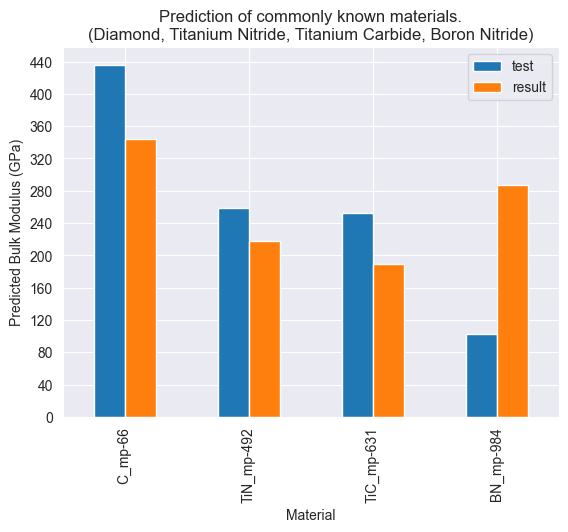

In [43]:
result_file = os.path.join(ROOT_DIR, "src/predict_common_publish.csv")

df = pd.read_csv(result_file)
print(df.head())
# df = df.sort_values(by='test', ascending=False)

lis = []
for i in df.to_dict(orient='split')['data']:
    result_dict = {}
    for j in materials:
        if j['material_id'] in i[0]:
            result_dict['material'] = i[0]
            result_dict['test'] = j['elasticity']['K_VRH']
            result_dict['result'] = i[-1]
        
    lis.append(result_dict)

df = pd.DataFrame(lis)
df = df.sort_values(by='test', ascending=False)
    
print(df)

print(f"Working on the bar plot...")
width = int((df.shape[0] * 1) / 5)
print(f"Widht = {width}")
ax = df.plot(
    x="material", 
    y=["test", "result"], 
    kind='bar',
    title=f"Prediction of commonly known materials.\n(Diamond, Titanium Nitride, Titanium Carbide, Boron Nitride)",
)
ax.set_xlabel("Material")
ax.set_ylabel("Predicted Bulk Modulus (GPa)")

# Show grid and increase y-axis ticks
ax.grid(True)
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))

print("Done creating plots")

In [ ]:
## Get the properties for the common materials
mpr = MPRester(API_TOKEN)
# mpr.materials.available_fields

crt = {
        'elements': {'$all': ['O']},
        'nelements': 3,
        # 'band_gap': {'$lt': 1},
    }
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 
            'unit_cell_formula', 'elements', 'elasticity','icsd_ids']

materials = mpr.query(criteria=crt, properties=prt)

100%|██████████| 21698/21698 [01:34<00:00, 228.42it/s]


In [ ]:
e_ovac_materials = [m for m in materials if 'O3' in m['pretty_formula']]

In [ ]:
print(len(e_ovac_materials))
e_ovac_materials[0]

4396


{'material_id': 'mp-1011260',
 'pretty_formula': 'EuFeO3',
 'full_formula': 'Eu2Fe2O6',
 'band_gap': 0.0,
 'unit_cell_formula': {'Eu': 2.0, 'Fe': 2.0, 'O': 6.0},
 'elements': ['Eu', 'Fe', 'O'],
 'elasticity': None,
 'icsd_ids': []}